* The following code is modified based on the original torchcv project. 
* We are going to use PASACAL VOC12 as dataset.
* You could donwload VOC2012 
  train/validation: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/#devkit
* test data: https://pjreddie.com/projects/pascal-voc-dataset-mirror/


In [1]:
import os
import cv2
import math
import random
import pickle
import argparse
import matplotlib.pyplot as plt
import matplotlib.image as pimg
from datetime import timedelta
import json

from PIL import Image
from time import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as T

from __future__ import print_function
from dbpn import Net as DBPN
from dbpn import get_pair_set
from ssd import SSD
from ssd import build_ssd
from ssd.layers.modules import MultiBoxLoss
from ssd.data.config import voc
from ssd.data import detection_collate
from ssd.data import VOCAnnotationTransform, VOCDetection, BaseTransform, SRDetection, DBPNLoader
from ssd.eval import test_net
from metric import *

import sys; sys.argv=['']; del sys

%matplotlib inline

# clean up device
torch.cuda.empty_cache()


## Visualization Charts

In [2]:
# Hi welcome to visualization fun!

# Helper function to plot images side-by-side with title
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(2.0 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    llen = 21
    for i in range(min(n_row * n_col, len(images))):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        title_i = np.str(titles[i])
        if len(title_i) >= llen:
            title_i = titles[i][:llen] + '\n' + titles[i][llen:]
        plt.title(title_i, size=12)
        plt.xticks(())
        plt.yticks(())

# Helper functions to plot multiple single scale curves
def plot_fig(xlabel, Xt, Xs, ylabel, title, Ys, colors, legends, filename = None):
    plt.figure(figsize=(18,6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(Xt, rotation = 90)
    plt.plot(Xs[0], Ys[0], colors[0], label=legends[0], lw=0.5, markersize=2.0)
    plt.plot(Xs[1], Ys[1], colors[1], label=legends[1], lw=0.5, markersize=2.0)
    plt.plot(Xs[2], Ys[2], colors[2], label=legends[2], lw=0.5, markersize=2.0)
    plt.legend(loc='upper right')
    if filename:
        plt.savefig(filename)
        plt.close(filename)
    else:
        plt.show()



In [3]:
# Load in trainval pickle data

# `a100b001.pkl` is pickled trainval data records for cost/loss critera: alpha = 1.00, beta=0.01
train_file = 'a100b001.pkl'
with open(train_file, mode='rb') as f:
    trainval = pickle.load(f)

###########################################
# Data is sampled at every 200 iterations #
# 1 epoch =5600 iteration/280 data points #
###########################################
#  X values: (iteration as sampling step) #
#   Iteration: defined as one batch proc: #
#   due to SROD model's hunger of memory, #
#   batch_size=2 (will need 5GB+ GPU mem) #
###########################################
iterns = trainval['iters']
epochs = trainval['epochs']
lrates = trainval['lrate']

###########################################
#      y values (choose one or other)     #
###########################################
# Mean Compound Loss btw. validation steps
m_loss = trainval['mloss']
# Mean Average Precision btw. validations
m_APes = trainval['m_aps']
# Mean Peak Signal to Noise Ratio in (dB)
m_psnr = trainval['mpsnr']
# Mean Structural Simarily Index (SSIM)
m_ssim = trainval['mssim']


iter_a = np.array(iterns)
loss_a = np.array(m_loss)
mAPs_a = np.array(m_APes)



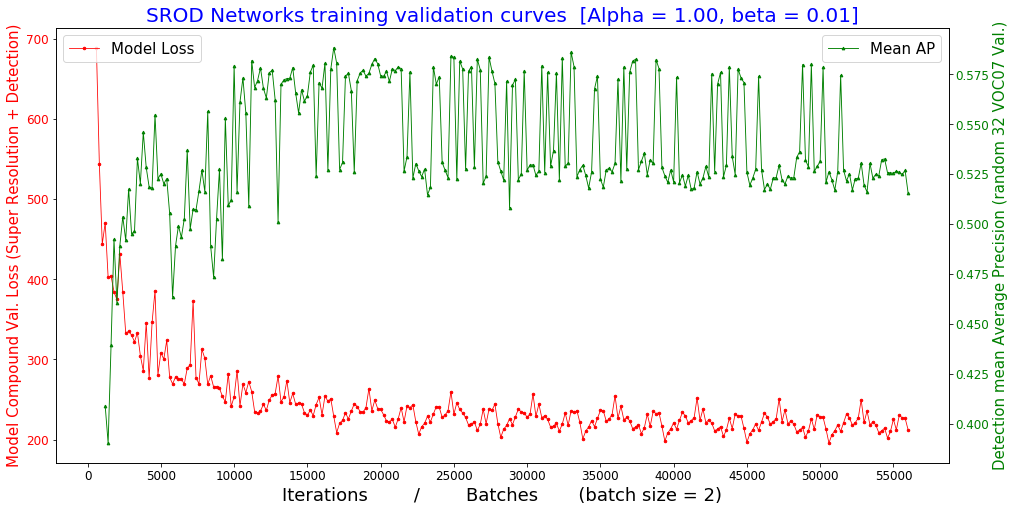

In [4]:
# Multiple plot of Dual scale Ys

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

plt.title('SROD Networks training validation curves  [Alpha = 1.00, beta = 0.01]', fontsize=20, color='b')

ax1.set_xlabel('Iterations        /        Batches       (batch size = 2)', fontsize=18)
ax1.set_ylabel('Model Compound Val. Loss (Super Resolution + Detection)', fontsize=15, color='r')
ax1.plot(iter_a[2:], loss_a[2:], 'ro-', label='Model Loss', lw=0.8, markersize=2.5)
ax1.legend(fontsize=15, loc='upper left')
ax1.tick_params(labelsize=12)
for tl in ax1.get_yticklabels():
    tl.set_color('r')


#plt.plot(iterns, m_APes, 'g^-', label='mAP')
#plt.plot(iterns, m_psnr, 'ro-', label='mPSNR')

ax2 = ax1.twinx()
ax2.set_ylabel('Detection mean Average Precision (random 32 VOC07 Val.)', fontsize=15, color='g')
ax2.plot(iter_a[5:], mAPs_a[5:], 'g^-', label='Mean AP', lw=0.9, markersize=2.7)
ax2.legend(fontsize=15, loc='upper right')
ax2.tick_params(labelsize=12)
for t2 in ax2.get_yticklabels():
    t2.set_color('g')

xtks = [i*5000 for i in range(0,12)]
plt.xticks(xtks, fontsize=50, rotation=0)
plt.show()


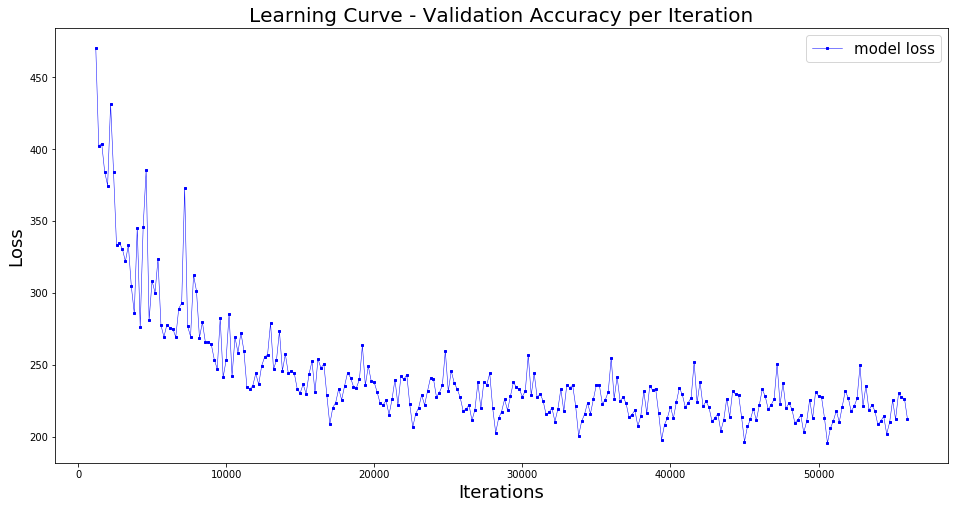

In [5]:
plt.figure(figsize=(16,8))
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title('Learning Curve - Validation Accuracy per Iteration', fontsize=20)
plt.plot(iter_a[5:], loss_a[5:], 'bs-', label='model loss', lw=0.5, markersize=2.0)
#plt.plot(iterns, m_APes, 'g^-', label='mAP')
#plt.plot(iterns, m_psnr, 'ro-', label='mPSNR')
plt.legend(fontsize=15, loc='upper right')
plt.show()

### Debugging code below, no need to run :)